In [1]:
import numpy as np
import matplotlib.pyplot as plt
import muram as mio
from astropy.io import fits
import pyflct
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/cmunrm.ttf'  # Your font path goes here
#font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 12
mpl.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#plt.rc('text', usetex=True)
plt.rc('axes', unicode_minus=False)

In [3]:
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress

In [4]:
def temporal_avg(data_in, start, end):
    tmp_avg = np.mean(data_in[start:end+1], axis = 0)
    return tmp_avg

In [5]:
def mean_v_from_file(file):
    v_x = fits.open(file)[0].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

def mean_vy_from_file(file):
    v_x = fits.open(file)[1].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

In [6]:
import seaborn as sns

<h3>FLCT Velocities</h3>
<p>
    First, we import FLCT velocities that were calculated without thresh parameter, i.e thresh = 0, meaning that all pixels were taken into consideration.
</p>

In [7]:
Vx_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")[0].data
Vy_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")[1].data

<p>
    Second, we import FLCT velocities calculated with thresh $\neq 0$, that is we set thresh = $\{50, 100\}G$, where G stands for Gauss (tracking was done on maps of $B_z$).
</p>

In [8]:
Vx_Bz1t50 = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_taum1T50_tracked.fits")[0].data
Vy_Bz1t50 = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_taum1T50_tracked.fits")[1].data

In [9]:
Vx_Bz1t100 = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_taum1T100_tracked.fits")[0].data
Vy_Bz1t100 = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_taum1T100_tracked.fits")[1].data

<h3>MURaM Velocities</h3>
<p>
    Importing the MURaM velocities with which we want to compare FLCT results and determine how much threshold affects the correlation
</p>

In [10]:
Vxm1 = fits.open("Velocities_TAU_0_1.fits")[1].data # Vy from Velocities.fits as originally thought
Vym1 = fits.open("Velocities_TAU_0_1.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm1 = Vxm1[::3]
Vym1 = Vym1[::3]
Vxm1 = Vxm1.transpose(0, 2, 1)
Vym1 = Vym1.transpose(0, 2, 1)

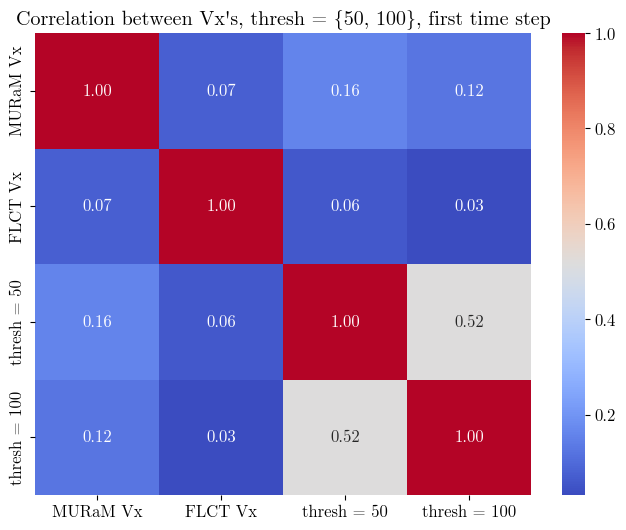

In [11]:
correlation_matrix = np.corrcoef([Vxm1[0,:,:].ravel(), Vx_Bz1[0, :,:].ravel(),
                     Vx_Bz1t50[0,:,:].ravel(), Vx_Bz1t100[0,:,:].ravel()])
                                   

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['MURaM Vx', 'FLCT Vx', 'thresh = 50', 'thresh = 100'],
            yticklabels=['MURaM Vx', 'FLCT Vx', 'thresh = 50', 'thresh = 100'])
plt.title("Correlation between Vx\'s, thresh = {50, 100}, first time step")
#plt.savefig("Vx_FE_cor.png", dpi = 70)
plt.show()

<p>
    As can be seen, correlation matrix isn't satisfactory for just a single time step in series. To test whether the correlation is bad for the whole series, we shall average series over 15 min, and convolve MURaM velocites with Gaussian FWHM = 300 km.
</p>

In [12]:
Vxm1_mean = temporal_avg(Vxm1, 0, 90)
Vxm1_mean = Vxm1_mean/1E5
Vym1_mean = temporal_avg(Vym1, 0, 90)
Vym1_mean = Vym1_mean/1E5

In [13]:
Vxm1_filtered300 = gaussian_filter(Vxm1_mean, 11.25, mode = "wrap")
Vym1_filtered300 = gaussian_filter(Vym1_mean, 11.25, mode = "wrap")

In [14]:
Vx_Bz1_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")
Vy_Bz1_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")

In [15]:
Vx_Bz1t50_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_taum1T50_tracked.fits")
Vy_Bz1t50_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_taum1T50_tracked.fits")

In [16]:
Vx_Bz1t100_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_taum1T100_tracked.fits")
Vy_Bz1t100_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_taum1T100_tracked.fits")

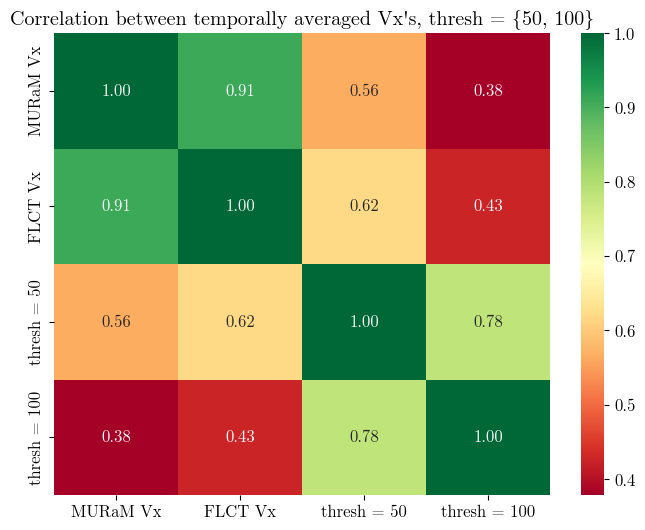

In [17]:
correlation_matrix = np.corrcoef([Vxm1_filtered300[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(),
                     Vx_Bz1t50_cor[:,:].ravel(), Vx_Bz1t100_cor[:,:].ravel()])
                                   

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['MURaM Vx', 'FLCT Vx', 'thresh = 50', 'thresh = 100'],
            yticklabels=['MURaM Vx', 'FLCT Vx', 'thresh = 50', 'thresh = 100'])
plt.title("Correlation between temporally averaged Vx\'s, thresh = {50, 100}")
#plt.savefig("Vx_FE_cor.png", dpi = 70)
plt.show()

<p>
    The correlation decreases as value of threshold parameter increases. This means that if we were to apply threshold = $B_z$ [G], we need to carefully test what absolute pixel value we can ignore without major reprecussions.
</p>

<p>
    Ignoring pixels can, in certain cases, be needed because of the map size (1536, 1536) or if the optical depth or height at which we are trying to recover flows doesn't exhibit features with magnetic field of stregth = threshold [G]. This also applies to other quantities that can be tracked (in units native to them, of course).
</p>